In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

<img src="../imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

## Official LightAutoML github repository is [here](https://github.com/sberbank-ai-lab/LightAutoML)

# Step 0.0. LightAutoML installation

This step can be used if you are working inside Google Colab/Kaggle kernels or want to install LightAutoML on your machine:

In [2]:
# !pip install -U lightautoml

# Step 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [3]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

# Step 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [4]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'TARGET'

In [5]:
DATASET_DIR = './data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/examples/data/sampled_app_train.csv'

# Step 0.3. Imported models setup

For better reproducibility we fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [6]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Data loading
Let's check the data we have:

In [7]:
%%time

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

CPU times: user 38 µs, sys: 0 ns, total: 38 µs
Wall time: 51.7 µs


In [8]:
%%time

data = pd.read_csv('./data/sampled_app_train.csv')
data.head()

CPU times: user 90.3 ms, sys: 30.8 ms, total: 121 ms
Wall time: 119 ms


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


In [9]:
data.shape

(10000, 122)

# Step 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [10]:
%%time

tr_data, te_data = train_test_split(data, 
                                    test_size=TEST_SIZE, 
                                    stratify=data[TARGET_NAME], 
                                    random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (8000, 122), te_data = (2000, 122)
CPU times: user 9.34 ms, sys: 1.01 ms, total: 10.4 ms
Wall time: 8.62 ms


In [11]:
tr_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
6444,112261,0,Cash loans,F,N,N,1,90000.0,640080.0,31261.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
3586,115058,0,Cash loans,F,N,Y,0,180000.0,239850.0,23850.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
9349,326623,0,Cash loans,F,N,Y,0,112500.0,337500.0,31086.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
7734,191976,0,Cash loans,M,Y,Y,1,67500.0,135000.0,9018.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2174,281519,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


# =========== LightAutoML model building ===========


# Step 1. Task setup

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [12]:
%%time

task = Task('binary', )

CPU times: user 5.05 ms, sys: 780 µs, total: 5.83 ms
Wall time: 5.13 ms


# Step 2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [13]:
%%time

roles = {'target': TARGET_NAME,
         'drop': ['SK_ID_CURR']
         }

CPU times: user 9 µs, sys: 6 µs, total: 15 µs
Wall time: 27.4 µs


# Step 3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="../imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [14]:
automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )

In [15]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1, log_file = 'train.log')
#print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

[10:04:07] Stdout logging level is INFO.
[10:04:07] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[10:04:07] Task: binary

[10:04:07] Start automl preset with listed constraints:
[10:04:07] - time: 300.00 seconds
[10:04:07] - CPU: 4 cores
[10:04:07] - memory: 16 GB

[10:04:07] Train data shape: (8000, 122)

[10:04:10] Layer 1 train process start. Time left 296.33 secs
[10:04:11] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:04:15] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7369812013107188
[10:04:15] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[10:04:15] Time left 291.91 secs

[10:04:18] Selector_LightGBM fitting and predicting completed
[10:04:18] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[10:04:40] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7453257333249144
[10:04:40] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[10:04:40] Start hyperparameters optimization for Lvl_

In [16]:
%%time 

RD = ReportDeco(output_path = 'tabularAutoML_model_report')
automl_rd = RD(automl)

oof_pred = automl_rd.fit_predict(tr_data, roles = roles, verbose = 3)
#print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

[10:07:58] Stdout logging level is INFO3.
[10:07:58] Task: binary

[10:07:58] Start automl preset with listed constraints:
[10:07:58] - time: 300.00 seconds
[10:07:58] - CPU: 4 cores
[10:07:58] - memory: 16 GB

[10:07:58] Train data shape: (8000, 122)

[10:07:59] Feats was rejected during automatic roles guess: []
[10:07:59] Layer 1 train process start. Time left 298.81 secs
[10:07:59] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:07:59] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[10:08:00] Linear model: C = 1e-05 score = 0.686047008889673
[10:08:00] Linear model: C = 5e-05 score = 0.7048874491503228
[10:08:00] Linear model: C = 0.0001 score = 0.7230142566191445
[10:08:00] Linear model: C = 0.0005 score = 0.7550502215736271
[10:08:00] Linear model: C = 0.001 score = 0.7629803657434878
[10:08:00] Linear model: C = 0.005 score = 0.7658429152567743
[10:08:00] Linear model: C = 0.01 score = 0.7634801759759663
[10:08:00] Linear model: C = 0.05 score = 0.753660

[10:08:40] [1]	valid's auc: 0.618605
[10:08:40] Training until validation scores don't improve for 100 rounds
[10:08:41] [100]	valid's auc: 0.743188
[10:08:42] [200]	valid's auc: 0.748652
[10:08:43] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[10:08:43] [1]	valid's auc: 0.610296
[10:08:43] Training until validation scores don't improve for 100 rounds
[10:08:44] [100]	valid's auc: 0.725135
[10:08:45] [200]	valid's auc: 0.727056
[10:08:46] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[10:08:46] [1]	valid's auc: 0.619271
[10:08:46] Training until validation scores don't improve for 100 rounds
[10:08:48] [100]	valid's auc: 0.731382
[10:08:49] [200]	valid's auc: 0.73231
[10:08:49] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[10:08:49] [1]	valid's auc: 0.674773
[10:08:49] Training until validation scores don't improve for 100 rounds
[10:08:51] [100]	valid's auc: 0.731063
[10:08:52] [200]	valid's au

[10:09:07] Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.6870065376247522 in 0:00:00.698786
[10:09:07] 0:	test: 0.5561338	best: 0.5561338 (0)	total: 5.11ms	remaining: 25.5s
[10:09:07] 99:	test: 0.7028615	best: 0.7129967 (81)	total: 328ms	remaining: 16.1s
[10:09:08] Stopped by overfitting detector  (100 iterations wait)
[10:09:08] bestTest = 0.7129966697
[10:09:08] bestIteration = 81
[10:09:08] Shrink model to first 82 iterations.
[10:09:08] Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.7129966697136382 in 0:00:00.745315
[10:09:08] 0:	test: 0.5299004	best: 0.5299004 (0)	total: 4.85ms	remaining: 24.3s
[10:09:08] 99:	test: 0.7590487	best: 0.7590487 (99)	total: 360ms	remaining: 17.6s
[10:09:09] 199:	test: 0.7630365	best: 0.7632931 (195)	total: 728ms	remaining: 17.5s
[10:09:09] 299:	test: 0.7626463	best: 0.7658322

[10:09:23] Stopped by overfitting detector  (100 iterations wait)
[10:09:23] bestTest = 0.7683339481
[10:09:23] bestIteration = 398
[10:09:23] Shrink model to first 399 iterations.
[10:09:23] Trial 17 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2304875676857797e-07, 'min_data_in_leaf': 17} scored 0.7683339480731913 in 0:00:01.478235
[10:09:23] 0:	test: 0.5227133	best: 0.5227133 (0)	total: 3.75ms	remaining: 18.7s
[10:09:24] 99:	test: 0.7527890	best: 0.7527890 (99)	total: 285ms	remaining: 14s
[10:09:24] 199:	test: 0.7553496	best: 0.7563278 (191)	total: 573ms	remaining: 13.8s
[10:09:24] 299:	test: 0.7566432	best: 0.7579261 (292)	total: 854ms	remaining: 13.4s
[10:09:25] Stopped by overfitting detector  (100 iterations wait)
[10:09:25] bestTest = 0.757926135
[10:09:25] bestIteration = 292
[10:09:25] Shrink model to first 293 iterations.
[10:09:25] Trial 18 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6893029457096831, 'min_data_in_l

[10:09:39] Trial 28 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.862349413814618, 'min_data_in_leaf': 6} scored 0.7691999294385555 in 0:00:01.750307
[10:09:39] 0:	test: 0.5111241	best: 0.5111241 (0)	total: 3.31ms	remaining: 16.6s
[10:09:39] 99:	test: 0.7478070	best: 0.7495443 (85)	total: 290ms	remaining: 14.2s
[10:09:40] 199:	test: 0.7524844	best: 0.7524844 (199)	total: 572ms	remaining: 13.7s
[10:09:40] 299:	test: 0.7512281	best: 0.7524844 (199)	total: 857ms	remaining: 13.4s
[10:09:40] Stopped by overfitting detector  (100 iterations wait)
[10:09:40] bestTest = 0.7524843509
[10:09:40] bestIteration = 199
[10:09:40] Shrink model to first 200 iterations.
[10:09:40] Trial 29 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5575412951227483, 'min_data_in_leaf': 3} scored 0.7524843508614377 in 0:00:01.029681
[10:09:40] 0:	test: 0.5227133	best: 0.5227133 (0)	total: 3.81ms	remaining: 19s
[10:09:40] 99:	test: 0.7451663	best: 0.7455084 (94)	

[10:09:56] Shrink model to first 98 iterations.
[10:09:56] Trial 39 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1576717178852784, 'min_data_in_leaf': 11} scored 0.7521849992783489 in 0:00:01.064575
[10:09:56] 0:	test: 0.5381299	best: 0.5381299 (0)	total: 3.75ms	remaining: 18.7s
[10:09:57] 99:	test: 0.7442736	best: 0.7442736 (99)	total: 335ms	remaining: 16.4s
[10:09:57] 199:	test: 0.7509555	best: 0.7523774 (189)	total: 666ms	remaining: 16s
[10:09:57] 299:	test: 0.7541682	best: 0.7542163 (298)	total: 986ms	remaining: 15.4s
[10:09:58] 399:	test: 0.7542591	best: 0.7572472 (322)	total: 1.3s	remaining: 15s
[10:09:58] Stopped by overfitting detector  (100 iterations wait)
[10:09:58] bestTest = 0.7572472484
[10:09:58] bestIteration = 322
[10:09:58] Shrink model to first 323 iterations.
[10:09:58] Trial 40 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.0138223845394365, 'min_data_in_leaf': 16} scored 0.7572472483709394 in 0:00:01.553292
[

[10:10:12] Shrink model to first 305 iterations.
[10:10:12] Trial 51 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.497898778317995, 'min_data_in_leaf': 4} scored 0.7701674765196103 in 0:00:01.444066
[10:10:12] 0:	test: 0.5262521	best: 0.5262521 (0)	total: 4.42ms	remaining: 22.1s
[10:10:12] 99:	test: 0.7569746	best: 0.7577123 (95)	total: 294ms	remaining: 14.4s
[10:10:12] 199:	test: 0.7624004	best: 0.7636619 (173)	total: 608ms	remaining: 14.6s
[10:10:13] 299:	test: 0.7629723	best: 0.7644958 (253)	total: 923ms	remaining: 14.5s
[10:10:13] 399:	test: 0.7695420	best: 0.7703439 (366)	total: 1.22s	remaining: 14s
[10:10:13] Stopped by overfitting detector  (100 iterations wait)
[10:10:13] bestTest = 0.7703438801
[10:10:13] bestIteration = 366
[10:10:13] Shrink model to first 367 iterations.
[10:10:13] Trial 52 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 7.7424122517025395, 'min_data_in_leaf': 8} scored 0.7703438801310734 in 0:00:01.585294


[10:10:29] bestTest = 0.7726852372
[10:10:29] bestIteration = 532
[10:10:29] Shrink model to first 533 iterations.
[10:10:29] Trial 62 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 9.985064457134023, 'min_data_in_leaf': 10} scored 0.7726852371559462 in 0:00:02.585863
[10:10:29] 0:	test: 0.5309669	best: 0.5309669 (0)	total: 4.72ms	remaining: 23.6s
[10:10:30] 99:	test: 0.7559590	best: 0.7588776 (72)	total: 407ms	remaining: 20s
[10:10:30] 199:	test: 0.7623576	best: 0.7634000 (174)	total: 819ms	remaining: 19.7s
[10:10:31] 299:	test: 0.7633572	best: 0.7657520 (258)	total: 1.2s	remaining: 18.8s
[10:10:31] 399:	test: 0.7663989	best: 0.7672381 (370)	total: 1.58s	remaining: 18.2s
[10:10:31] Stopped by overfitting detector  (100 iterations wait)
[10:10:31] bestTest = 0.7672381075
[10:10:31] bestIteration = 370
[10:10:31] Shrink model to first 371 iterations.
[10:10:31] Trial 63 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.581909330643884, 'm

[10:10:46] 399:	test: 0.7706860	best: 0.7710869 (314)	total: 1.38s	remaining: 15.9s
[10:10:46] 499:	test: 0.7666822	best: 0.7718941 (430)	total: 1.73s	remaining: 15.6s
[10:10:46] Stopped by overfitting detector  (100 iterations wait)
[10:10:46] bestTest = 0.7718940937
[10:10:46] bestIteration = 430
[10:10:46] Shrink model to first 431 iterations.
[10:10:46] Trial 74 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.259645022143254, 'min_data_in_leaf': 12} scored 0.7718940936863544 in 0:00:02.024174
[10:10:46] 0:	test: 0.5316083	best: 0.5316083 (0)	total: 4.16ms	remaining: 20.8s
[10:10:47] 99:	test: 0.7597169	best: 0.7615772 (90)	total: 371ms	remaining: 18.2s
[10:10:47] 199:	test: 0.7593267	best: 0.7643996 (124)	total: 743ms	remaining: 17.8s
[10:10:47] Stopped by overfitting detector  (100 iterations wait)
[10:10:47] bestTest = 0.764399613
[10:10:47] bestIteration = 124
[10:10:47] Shrink model to first 125 iterations.
[10:10:47] Trial 75 with hyperparameters {'ma

[10:11:02] 199:	test: 0.7622186	best: 0.7641537 (178)	total: 686ms	remaining: 16.5s
[10:11:02] 299:	test: 0.7674038	best: 0.7695902 (265)	total: 1.03s	remaining: 16.1s
[10:11:02] Stopped by overfitting detector  (100 iterations wait)
[10:11:02] bestTest = 0.7695901556
[10:11:02] bestIteration = 265
[10:11:02] Shrink model to first 266 iterations.
[10:11:02] Trial 87 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.6453490135715485, 'min_data_in_leaf': 6} scored 0.7695901556093676 in 0:00:01.416236
[10:11:02] 0:	test: 0.5365556	best: 0.5365556 (0)	total: 5.58ms	remaining: 27.9s
[10:11:03] 99:	test: 0.7507150	best: 0.7507150 (99)	total: 422ms	remaining: 20.7s
[10:11:03] 199:	test: 0.7598452	best: 0.7611655 (169)	total: 894ms	remaining: 21.4s
[10:11:04] 299:	test: 0.7600109	best: 0.7650411 (228)	total: 1.37s	remaining: 21.5s
[10:11:04] Stopped by overfitting detector  (100 iterations wait)
[10:11:04] bestTest = 0.7650410807
[10:11:04] bestIteration = 228
[10:11:04

[10:11:20] 299:	test: 0.7634802	best: 0.7648166 (247)	total: 1.16s	remaining: 18.1s
[10:11:21] 399:	test: 0.7687776	best: 0.7706646 (366)	total: 1.52s	remaining: 17.5s
[10:11:21] Stopped by overfitting detector  (100 iterations wait)
[10:11:21] bestTest = 0.770664614
[10:11:21] bestIteration = 366
[10:11:21] Shrink model to first 367 iterations.
[10:11:21] Trial 98 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.401291403735577, 'min_data_in_leaf': 13} scored 0.7706646139700969 in 0:00:01.949971
[10:11:21] 0:	test: 0.5290478	best: 0.5290478 (0)	total: 4.68ms	remaining: 23.4s
[10:11:21] 99:	test: 0.7583110	best: 0.7590113 (95)	total: 392ms	remaining: 19.2s
[10:11:22] 199:	test: 0.7610747	best: 0.7640842 (171)	total: 778ms	remaining: 18.7s
[10:11:22] Stopped by overfitting detector  (100 iterations wait)
[10:11:22] bestTest = 0.7640842247
[10:11:22] bestIteration = 171
[10:11:22] Shrink model to first 172 iterations.
[10:11:22] Trial 99 with hyperparameters {'ma

In [17]:
print(automl_rd.model.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.24089 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.39882 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.15513 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.20515 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


# Step 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In the cell below we will use `automl_rd.model` instead `automl_rd` because we want to take the importances from the model, not from the report. But **be carefull** - everything, which is calculated using `automl_rd.model` will not go to the report.

CPU times: user 271 ms, sys: 598 µs, total: 272 ms
Wall time: 265 ms


<AxesSubplot:xlabel='Feature'>

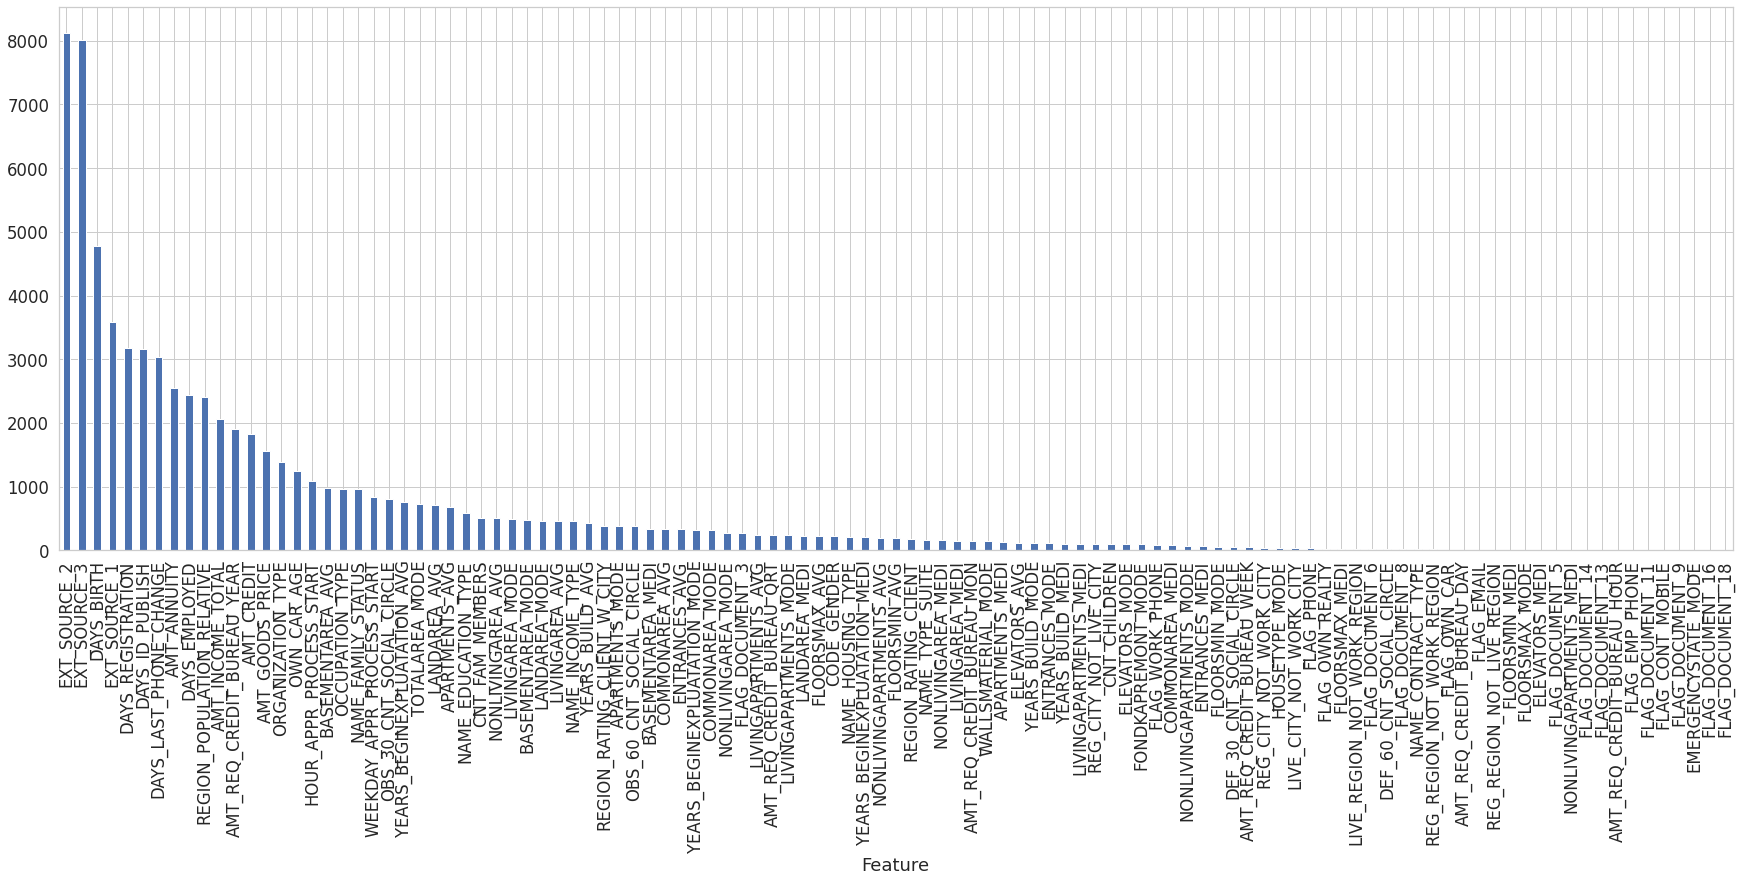

In [18]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [19]:
# %%time

# # Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
# accurate_fi = automl_rd.model.get_feature_scores('accurate', te_data, silent = False)

In [20]:
# accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# Step 5. Prediction on holdout and metric calculation

In [21]:
%%time

te_pred = automl_rd.predict(te_data)
print('Prediction for te_data:\n{}\nShape = {}'
              .format(te_pred, te_pred.shape))

Prediction for te_data:
array([[0.05149722],
       [0.06560664],
       [0.02136721],
       ...,
       [0.04655124],
       [0.03480342],
       [0.200952  ]], dtype=float32)
Shape = (2000, 1)
CPU times: user 9.33 s, sys: 607 ms, total: 9.94 s
Wall time: 2.06 s


In [22]:
print('Check scores...')
print('OOF score: {}'.format(roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])))
print('HOLDOUT score: {}'.format(roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])))

Check scores...
OOF score: 0.7554924560115602
HOLDOUT score: 0.7311141304347827


# Bonus. Where is the automatic report?

As we used `automl_rd` in our training and prediction cells, it is already ready in the folder we specified - you can check the output kaggle folder and find the `tabularAutoML_model_report` folder with `lama_interactive_report.html` report inside (or just [click this link](tabularAutoML_model_report/lama_interactive_report.html) for short). It's interactive so you can click the black triangles on the left of the texts to go deeper in selected part.

# Step 6. Spending more from TIMEOUT - `TabularUtilizedAutoML` usage

Using `TabularAutoML` we spent only 31 second to build the model with setup `TIMEOUT` equal to 5 minutes. To spend (almost) all the `TIMEOUT` we can use `TabularUtilizedAutoML` preset instead of `TabularAutoML`, which has the same API:

In [23]:
utilized_automl = TabularUtilizedAutoML(task = task, 
                               timeout = 600,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                              )

In [24]:
%%time 

oof_pred = utilized_automl.fit_predict(tr_data, roles = roles, verbose = 1)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

[10:11:39] Start automl utilizator with listed constraints:
[10:11:39] - time: 600.00 seconds
[10:11:39] - CPU: 4 cores
[10:11:39] - memory: 16 GB

[10:11:39] If one preset completes earlier, next preset configuration will be started

[10:11:39] ==================================================
[10:11:39] Start 0 automl preset configuration:
[10:11:39] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[10:11:39] Stdout logging level is INFO.
[10:11:39] Task: binary

[10:11:39] Start automl preset with listed constraints:
[10:11:39] - time: 600.00 seconds
[10:11:39] - CPU: 4 cores
[10:11:39] - memory: 16 GB

[10:11:39] Train data shape: (8000, 122)

[10:11:41] Layer 1 train process start. Time left 598.89 secs
[10:11:41] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:11:45] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7369812013107188
[10:11:45] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicti

In [25]:
print(utilized_automl.create_model_str_desc())

Final prediction for new objects = 
	0.66439 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.23607 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.27962 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.48431 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.33561 * 1 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.29451 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.30908 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.17342 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.22300 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 





# Step 7. Feature importances calculation for `TabularUtilizedAutoML`

CPU times: user 158 ms, sys: 12.1 ms, total: 170 ms
Wall time: 162 ms


<AxesSubplot:xlabel='Feature'>

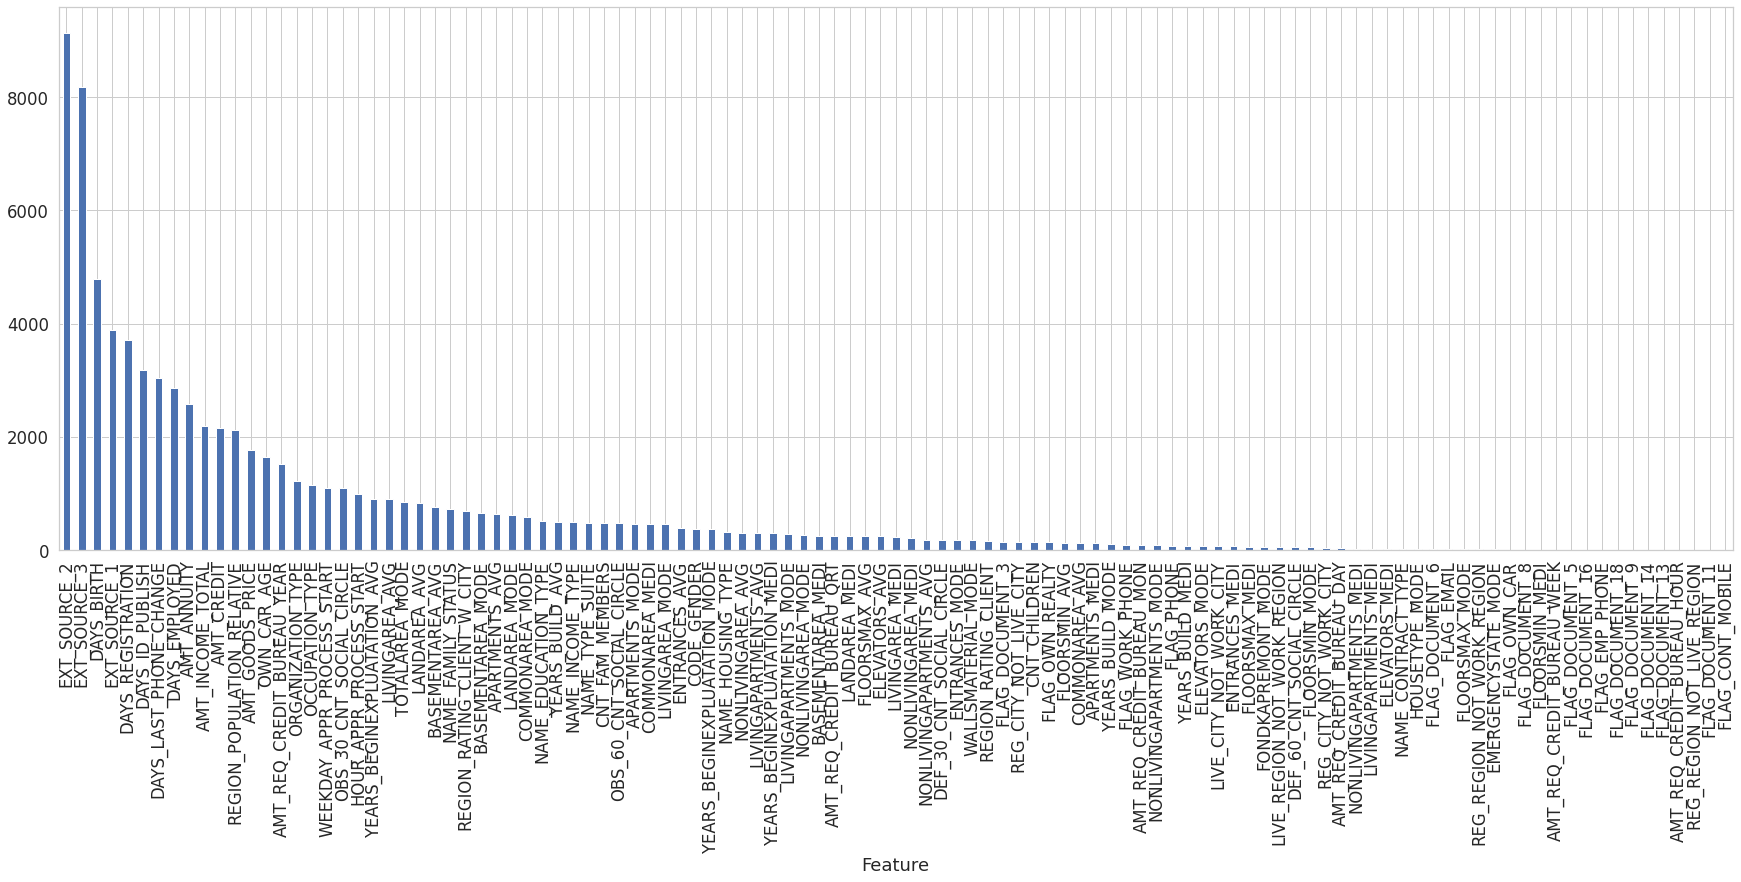

In [26]:
%%time

# Fast feature importances calculation
fast_fi = utilized_automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# Step 8. Prediction on holdout and metric calculation

In [27]:
%%time

te_pred = utilized_automl.predict(te_data)
print('Prediction for te_data:\n{}\nShape = {}'
              .format(te_pred, te_pred.shape))

Prediction for te_data:
array([[0.06234013],
       [0.07144924],
       [0.02687698],
       ...,
       [0.05742646],
       [0.04061448],
       [0.21737626]], dtype=float32)
Shape = (2000, 1)
CPU times: user 15.2 s, sys: 1.56 s, total: 16.7 s
Wall time: 1.07 s


In [28]:
print('Check scores...')
print('OOF score: {}'.format(roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])))
print('HOLDOUT score: {}'.format(roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])))

Check scores...
OOF score: 0.7581318793225473
HOLDOUT score: 0.734375


# Additional materials

- [Official LightAutoML github repo](https://github.com/sberbank-ai-lab/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)